# Time series

## Import data

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [140]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 45.6536,
    "longitude": 5.8549,
    "start_date": "1970-11-02",
    "end_date": "2024-11-16",
    "hourly": ["temperature_2m", "rain", "weather_code"],
    "temporal_resolution": "hourly_3",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    )
}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["weather_code"] = hourly_weather_code

hourly_dataframe = pd.DataFrame(data=hourly_data).set_index("date")
print(hourly_dataframe)

Coordinates 45.65904998779297°N 5.6692914962768555°E
Elevation 305.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           temperature_2m  rain  weather_code
date                                                         
1970-11-02 00:00:00+00:00           6.105   0.0           0.0
1970-11-02 03:00:00+00:00           5.055   0.0           2.0
1970-11-02 06:00:00+00:00           4.205   0.0           3.0
1970-11-02 09:00:00+00:00          11.905   0.0           3.0
1970-11-02 12:00:00+00:00          18.705   0.0           3.0
...                                   ...   ...           ...
2024-11-16 09:00:00+00:00           4.129   0.0           3.0
2024-11-16 12:00:00+00:00           9.579   0.0           1.0
2024-11-16 15:00:00+00:00           6.779   0.0           0.0
2024-11-16 18:00:00+00:00           1.329   0.0           0.0
2024-11-16 21:00:00+00:00           1.029   0.0           0.0

[157912 rows x 3 columns]


In [ ]:
hourly_dataframe.index

DatetimeIndex(['2004-11-02 00:00:00+00:00', '2004-11-02 03:00:00+00:00',
               '2004-11-02 06:00:00+00:00', '2004-11-02 09:00:00+00:00',
               '2004-11-02 12:00:00+00:00', '2004-11-02 15:00:00+00:00',
               '2004-11-02 18:00:00+00:00', '2004-11-02 21:00:00+00:00',
               '2004-11-03 00:00:00+00:00', '2004-11-03 03:00:00+00:00',
               ...
               '2024-11-15 18:00:00+00:00', '2024-11-15 21:00:00+00:00',
               '2024-11-16 00:00:00+00:00', '2024-11-16 03:00:00+00:00',
               '2024-11-16 06:00:00+00:00', '2024-11-16 09:00:00+00:00',
               '2024-11-16 12:00:00+00:00', '2024-11-16 15:00:00+00:00',
               '2024-11-16 18:00:00+00:00', '2024-11-16 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=58560, freq=None)

<Axes: xlabel='date'>

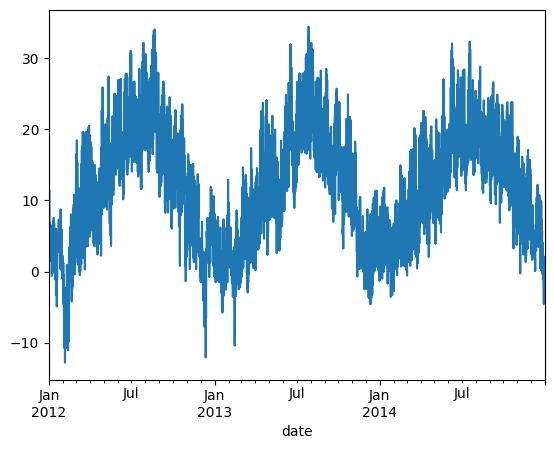

In [5]:
hourly_dataframe["2012":"2014"]["temperature_2m"].plot()

## Resample

<Axes: xlabel='date'>

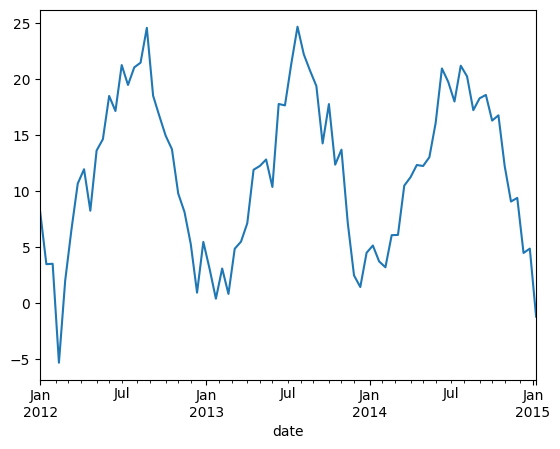

In [10]:
hourly_dataframe["2012":"2014"]["temperature_2m"].resample('2W').mean().plot()

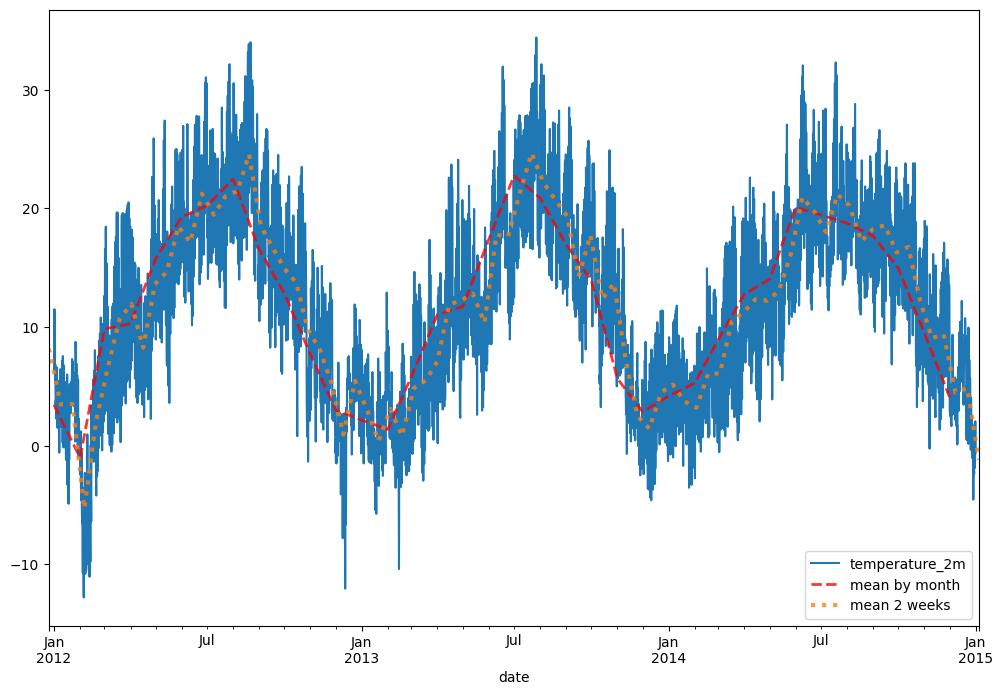

In [25]:
import matplotlib.pyplot as plt

to_plot = hourly_dataframe["2012":"2014"]["temperature_2m"]

plt.figure(figsize=(12, 8))
to_plot.plot()
to_plot.resample('ME').mean().plot(label='mean by month', lw=2, ls='--', alpha=0.8, c="Red")
to_plot.resample('2W').mean().plot(label='mean 2 weeks', lw=3, ls=':', alpha=0.8)
plt.legend()

## Aggregate

In [ ]:
m = to_plot.resample('W').agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(12, 8))
m['mean']["2012":"2014"].plot(label='mean by weeks')
m['std']["2012":"2014"].plot(label='std by weeks')
plt.fill_between(m.index, m['max'], m['min'], alpha=0.2, label='min-max by weeks')


plt.legend()

In [23]:
m.head()

mean       std    min     max
date                                                        
2012-01-01 00:00:00+00:00  8.198750  2.030031  6.405  11.505
2012-01-08 00:00:00+00:00  4.177321  1.658091 -0.595   6.855
2012-01-15 00:00:00+00:00  2.786250  2.306543 -1.095   7.555
2012-01-22 00:00:00+00:00  2.577322  3.137007 -4.895   7.305
2012-01-29 00:00:00+00:00  4.460357  2.106390 -0.195   8.755

In [81]:
to_plot

date
2012-01-01 00:00:00+00:00     6.405
2012-01-01 03:00:00+00:00     6.655
2012-01-01 06:00:00+00:00     6.455
2012-01-01 09:00:00+00:00     8.405
2012-01-01 12:00:00+00:00    11.505
                              ...  
2014-12-31 09:00:00+00:00    -1.095
2014-12-31 12:00:00+00:00     1.555
2014-12-31 15:00:00+00:00     2.055
2014-12-31 18:00:00+00:00     0.255
2014-12-31 21:00:00+00:00    -0.595
Name: temperature_2m, Length: 8768, dtype: float32

In [95]:
hourly_dataframe["2012":"2014"]

temperature_2m  rain  weather_code
date                                                         
2012-01-01 00:00:00+00:00           6.405   2.3          53.0
2012-01-01 03:00:00+00:00           6.655   1.7          53.0
2012-01-01 06:00:00+00:00           6.455   0.1          51.0
2012-01-01 09:00:00+00:00           8.405   0.8          51.0
2012-01-01 12:00:00+00:00          11.505   0.0           3.0
...                                   ...   ...           ...
2014-12-31 09:00:00+00:00          -1.095   0.0           2.0
2014-12-31 12:00:00+00:00           1.555   0.0           3.0
2014-12-31 15:00:00+00:00           2.055   0.0           2.0
2014-12-31 18:00:00+00:00           0.255   0.0           0.0
2014-12-31 21:00:00+00:00          -0.595   0.0           0.0

[8768 rows x 3 columns]

In [102]:
hourly_dataframe["2012":"2014"].index.name

'date'

In [106]:
hourly_dataframe["2012":"2014"].reset_index()

date  temperature_2m  rain  weather_code
0    2012-01-01 00:00:00+00:00           6.405   2.3          53.0
1    2012-01-01 03:00:00+00:00           6.655   1.7          53.0
2    2012-01-01 06:00:00+00:00           6.455   0.1          51.0
3    2012-01-01 09:00:00+00:00           8.405   0.8          51.0
4    2012-01-01 12:00:00+00:00          11.505   0.0           3.0
...                        ...             ...   ...           ...
8763 2014-12-31 09:00:00+00:00          -1.095   0.0           2.0
8764 2014-12-31 12:00:00+00:00           1.555   0.0           3.0
8765 2014-12-31 15:00:00+00:00           2.055   0.0           2.0
8766 2014-12-31 18:00:00+00:00           0.255   0.0           0.0
8767 2014-12-31 21:00:00+00:00          -0.595   0.0           0.0

[8768 rows x 4 columns]

<Figure size 2000x5000 with 0 Axes>

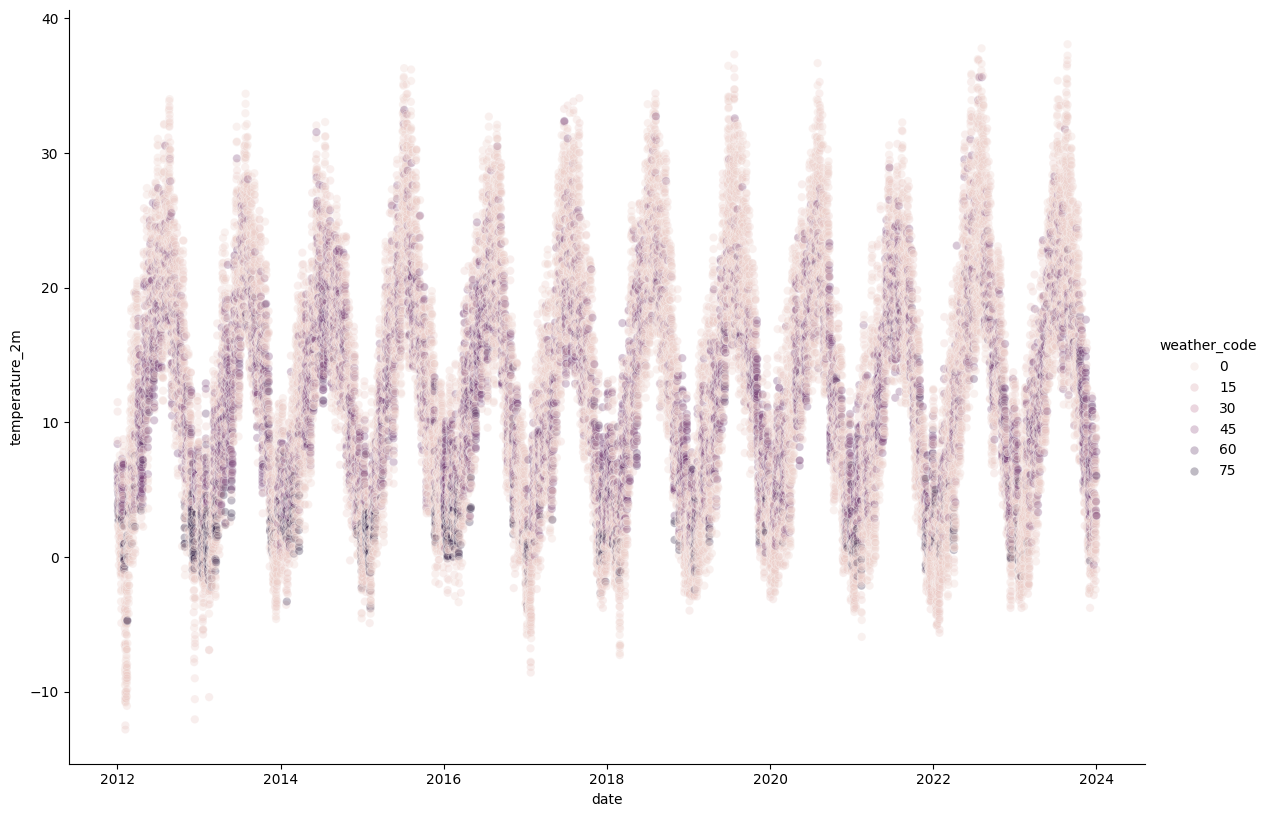

In [ ]:
sns.relplot(x='date', y="temperature_2m", data=hourly_dataframe["2012":"2023"], hue="weather_code", alpha=0.3, height=8.27, aspect=11.7/8.27)

In [141]:
only_snow = hourly_dataframe["1970":"2023"][hourly_dataframe["1970":"2023"]["weather_code"] >= 75]

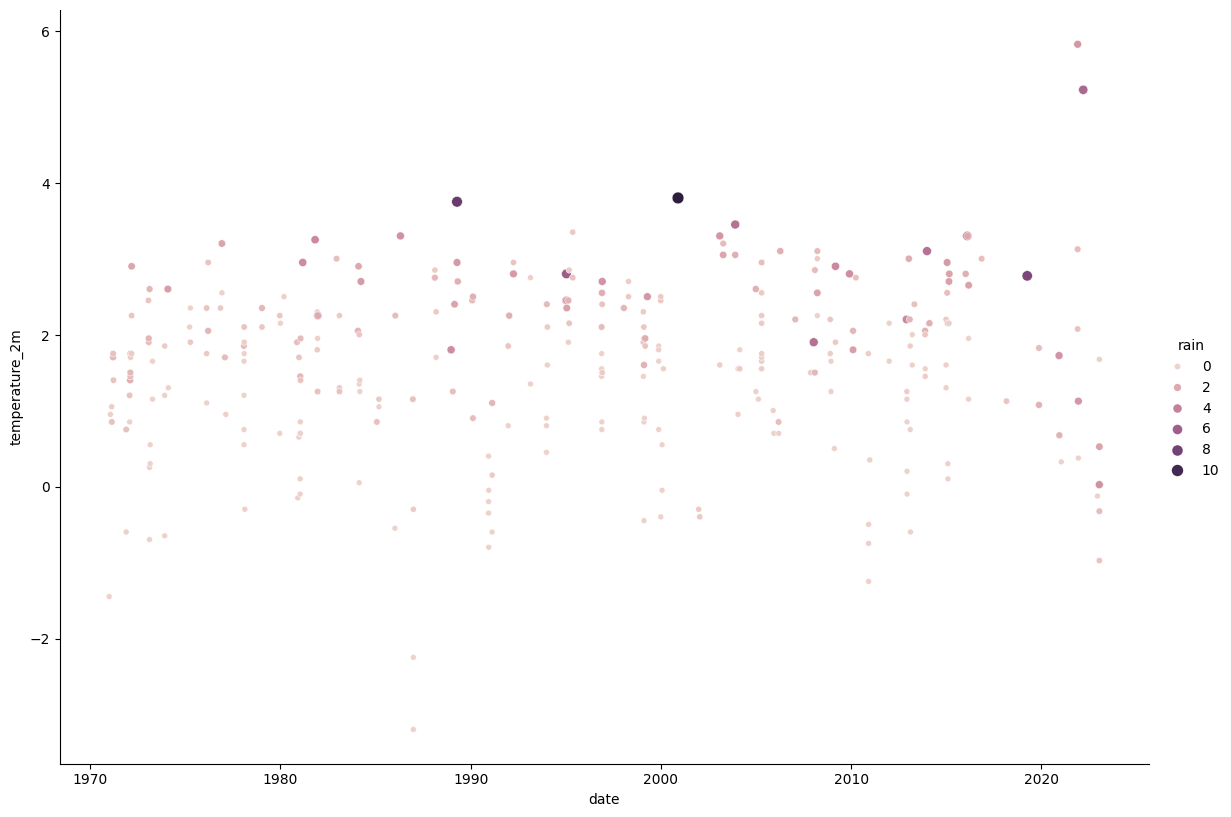

In [142]:
sns.relplot(x='date', y="temperature_2m", data=only_snow, hue="rain" , size="rain", height=8.27, aspect=11.7/8.27)

In [179]:
sns.lineplot(x='date', y="rain", data=only_snow.resample("YE").sum())

<Axes: xlabel='date', ylabel='rain'>

## Corelation

In [76]:
corr = hourly_dataframe.corr()
corr.style.background_gradient(cmap='Blues')

## Merge

to do this we add new dataset

<Axes: xlabel='date'>

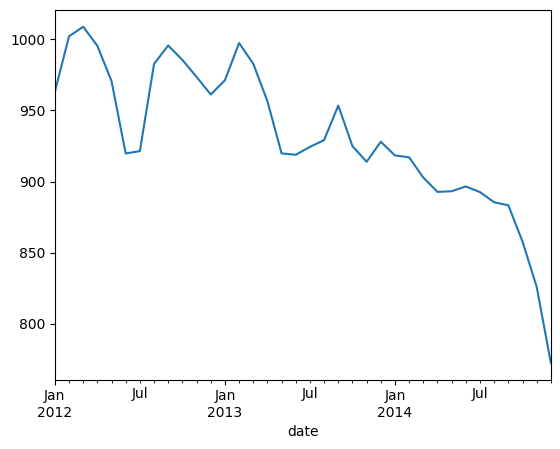

In [55]:
data_fuel = pd.read_csv("../../data/fuel_valeurs_mensuelles.csv", index_col="Datetime", parse_dates=True, usecols=["Datetime", "Prix_1000_litres"])
data_fuel = data_fuel.sort_index()
data_fuel.index.names =  ["date"]
data_fuel =  data_fuel.tz_localize(tz='Europe/Paris')
data_fuel["2012":"2014"]["Prix_1000_litres"].plot()

And we merge the two data set on the month frequency 

In [68]:
merge_df = pd.merge(hourly_dataframe, data_fuel, on="date", how="outer")

merge_df_to_plot = merge_df["2012":"2014"]

plt.figure(figsize=(12, 8))
merge_df_to_plot[["temperature_2m", "Prix_1000_litres"]].resample('ME').mean().plot(subplots=True, lw=2, alpha=0.8,)
plt.legend()

<Figure size 1200x800 with 0 Axes>

In [67]:
merge_df_to_plot[["temperature_2m", "Prix_1000_litres"]].resample('ME').mean().corr()

temperature_2m  Prix_1000_litres
temperature_2m          1.000000         -0.094899
Prix_1000_litres       -0.094899          1.000000